<a href="https://colab.research.google.com/github/Fedesin/Challenge-ML/blob/main/Colab_challenge_meli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
! pip install kaggle
!pip install pycountry pycountry-convert pandas

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/"Challenge ML"/Kaggle_API/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download konradb/atticus-open-contract-dataset-aok-beta

Dataset URL: https://www.kaggle.com/datasets/konradb/atticus-open-contract-dataset-aok-beta
License(s): Attribution 4.0 International (CC BY 4.0)
 83% 85.0M/102M [00:00<00:00, 132MB/s]
100% 102M/102M [00:00<00:00, 124MB/s] 


In [8]:
! unzip atticus-open-contract-dataset-aok-beta.zip

Archive:  atticus-open-contract-dataset-aok-beta.zip
  inflating: CUAD_v1/CUAD_v1.json    
  inflating: CUAD_v1/CUAD_v1_README.txt  
  inflating: CUAD_v1/full_contract_pdf/Part_I/Affiliate_Agreements/CreditcardscomInc_20070810_S-1_EX-10.33_362297_EX-10.33_Affiliate Agreement.pdf  
  inflating: CUAD_v1/full_contract_pdf/Part_I/Affiliate_Agreements/CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605784_EX-10.27_Affiliate Agreement.pdf  
  inflating: CUAD_v1/full_contract_pdf/Part_I/Affiliate_Agreements/DigitalCinemaDestinationsCorp_20111220_S-1_EX-10.10_7346719_EX-10.10_Affiliate Agreement.pdf  
  inflating: CUAD_v1/full_contract_pdf/Part_I/Affiliate_Agreements/LinkPlusCorp_20050802_8-K_EX-10_3240252_EX-10_Affiliate Agreement.pdf  
  inflating: CUAD_v1/full_contract_pdf/Part_I/Affiliate_Agreements/SouthernStarEnergyInc_20051202_SB-2A_EX-9_801890_EX-9_Affiliate Agreement.pdf  
  inflating: CUAD_v1/full_contract_pdf/Part_I/Affiliate_Agreements/SteelVaultCorp_20081224_10-K_EX-10.16_3074935_EX-10

In [249]:
import os
import pandas as pd
import numpy as np
import re
import pycountry
import pycountry_convert as pc

In [344]:
dataset_path = '/content/CUAD_v1/'
master_csv_path = os.path.join(dataset_path, 'master_clauses.csv') #Extract

In [345]:
print(os.listdir(dataset_path))

['CUAD_v1_README.txt', 'full_contract_txt', 'master_clauses.csv', 'full_contract_pdf', 'CUAD_v1.json', 'label_group_xlsx']


In [460]:
df_master = pd.read_csv(master_csv_path)

In [83]:
print(df_master.head())
print(df_master.columns)
print(f"El DataFrame tiene {df_master.shape[0]} filas y {df_master.shape[1]} columnas.")

                                            Filename  \
0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1  EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2  FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3  GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4  IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   

                                    Document Name  \
0               ['MARKETING AFFILIATE AGREEMENT']   
1   ['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT']   
2  ['CONTENT DISTRIBUTION AND LICENSE AGREEMENT']   
3           ['WEBSITE CONTENT LICENSE AGREEMENT']   
4                   ['CONTENT LICENSE AGREEMENT']   

                         Document Name-Answer  \
0               MARKETING AFFILIATE AGREEMENT   
1   VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT   
2  CONTENT DISTRIBUTION AND LICENSE AGREEMENT   
3           WEBSITE CONTENT LICENSE AGREEMENT   
4                   CONTENT LICENSE AGREEMENT   

                                             Part

In [77]:
#Observo las primeras filas del DataFrame para verificar que este todo en orden
print("Primeras filas del DataFrame limpio:")
print(df_master.head())

# Mostrar algunas filas de cada columna clave para revisar contenido
print("Contenido de 'Parties-Answer':")
print(df_master['Parties-Answer'].head(10))

print("Contenido de 'Agreement Date-Answer':")
print(df_master['Agreement Date-Answer'].head(10))

print("Contenido de 'Renewal Term-Answer':")
print(df_master['Renewal Term-Answer'].head(10))

print("Contenido de 'Governing Law-Answer':")
print(df_master['Governing Law-Answer'].head(10))

Primeras filas del DataFrame limpio:
                                            Filename  \
0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1  EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2  FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3  GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4  IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   

                                    Document Name  \
0               ['MARKETING AFFILIATE AGREEMENT']   
1   ['VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT']   
2  ['CONTENT DISTRIBUTION AND LICENSE AGREEMENT']   
3           ['WEBSITE CONTENT LICENSE AGREEMENT']   
4                   ['CONTENT LICENSE AGREEMENT']   

                         Document Name-Answer  \
0               MARKETING AFFILIATE AGREEMENT   
1   VIDEO-ON-DEMAND CONTENT LICENSE AGREEMENT   
2  CONTENT DISTRIBUTION AND LICENSE AGREEMENT   
3           WEBSITE CONTENT LICENSE AGREEMENT   
4                   CONTENT LICENSE AGREEMENT   

            

Fase de Transformación, vamos a comenzar limpiando las columnas que coinsideramos claves para responder las preguntas del challenge.

In [325]:
# Seleccionar solo las columnas necesarias para el análisis
columnas_importantes = [
    'Filename',  # Para tener referencia del nombre del archivo
    'Parties-Answer',  # Proveedores involucrados
    'Agreement Date-Answer',  # Fecha de firma del contrato
    'Effective Date-Answer',  # Fecha en que el contrato se vuelve efectivo
    'Expiration Date-Answer',  # Fecha de expiración del contrato
    'Renewal Term-Answer',  # Plazo de renovación del contrato
    'Governing Law-Answer'  # País cuya ley rige el contrato
]

In [483]:
# Crear un nuevo DataFrame con las columnas seleccionadas
df_filtrado = df_master[columnas_importantes].copy()

# Mostrar las primeras filas del DataFrame filtrado para verificar
print("Primeras filas del DataFrame filtrado:")
print(df_filtrado.head())

Primeras filas del DataFrame filtrado:
                                            Filename  \
0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1  EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2  FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3  GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4  IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   

                                      Parties-Answer Agreement Date-Answer  \
0  Birch First Global Investments Inc. ("Company"...                5/8/14   
1  Rogers Cable Communications Inc. ("Rogers"); E...               7/11/06   
2  CONVERGTV, INC. (“ConvergTV”); Fulucai Product...              11/15/12   
3  PSiTech Corporation ("Licensor"); Empirical Ve...               2/10/14   
4  Beijing Sun Seven Stars Culture Development Li...              12/21/15   

  Effective Date-Answer Expiration Date-Answer    Renewal Term-Answer  \
0                   NaN               12/31/14      successive 1 year   
1        

In [298]:
#Verificacion del DataFrame filtrado
print("Contenido de 'Parties-Answer' (primeras 10 filas):")
print(df_filtrado['Parties-Answer'].head(10))

print("Contenido de 'Agreement Date-Answer' (primeras 10 filas):")
print(df_filtrado['Agreement Date-Answer'].head(10))

print("Contenido de 'Effective Date-Answer' (primeras 10 filas):")
print(df_filtrado['Effective Date-Answer'].head(10))

print("Contenido de 'Renewal Term-Answer' (primeras 10 filas):")
print(df_filtrado['Renewal Term-Answer'].head(10))

print("Contenido de 'Governing Law-Answer' (primeras 10 filas):")
print(df_filtrado['Governing Law-Answer'].head(10))

Contenido de 'Parties-Answer' (primeras 10 filas):
0    Birch First Global Investments Inc. ("Company"...
1    Rogers Cable Communications Inc. ("Rogers"); E...
2    CONVERGTV, INC. (“ConvergTV”); Fulucai Product...
3    PSiTech Corporation ("Licensor"); Empirical Ve...
4    Beijing Sun Seven Stars Culture Development Li...
5    RSL COM PrimeCall, Inc. ("PrimeCall"); deltath...
6    WOMEN.COM NETWORKS, INC. ("Women.com"); EDIETS...
7    INTEGRITY INCORPORATED ("Integrity"); TIME LIF...
8    Marine MP, LLC (“Lender”); Arnold Schwarzenegg...
9    Skype Communications, S.A. ("Skype"); Skype Te...
Name: Parties-Answer, dtype: object
Contenido de 'Agreement Date-Answer' (primeras 10 filas):
0      5/8/14
1     7/11/06
2    11/15/12
3     2/10/14
4    12/21/15
5     10/1/99
6     5/22/00
7     1/10/00
8     7/26/13
9     8/22/05
Name: Agreement Date-Answer, dtype: object
Contenido de 'Effective Date-Answer' (primeras 10 filas):
0         NaN
1     7/11/06
2    11/15/12
3     2/10/14
4    12/

Limpieza

Frecuencia de proveedores:
                                  Proveedor  Cantidad de Contratos
0                        VerticalNet, Inc.                      4
1      FEDERATED ADVISORY SERVICES COMPANY                      4
2  FEDERATED INVESTMENT MANAGEMENT COMPANY                      4
3                            NETGEAR, Inc.                      3
4            Premier Nutrition Corporation                      3
5                             Excite, Inc.                      3
6                               Franchisee                      3
7                    Bank of America, N.A.                      3
8                         HOF Village, LLC                      3
9                             Ingram Micro                      3
Proveedor con más contratos asociados: VerticalNet, Inc., con 4 contratos.


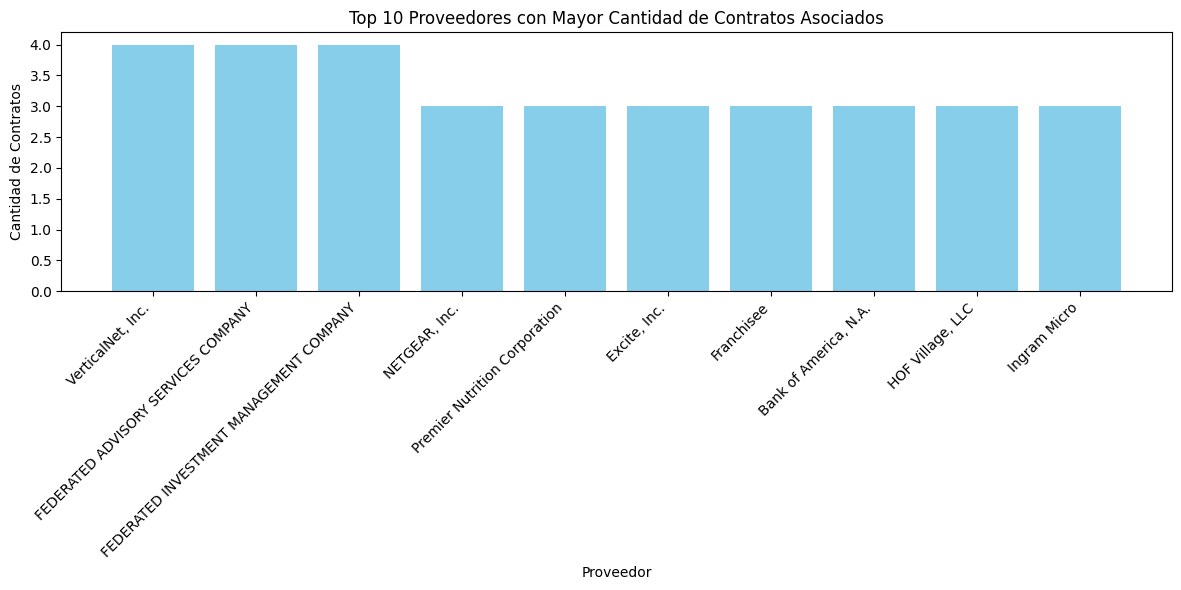

In [484]:
# Limpieza de 'Parties-Answer' con verificación adicional para evitar errores
df_filtrado['Parties-Answer'] = df_filtrado['Parties-Answer'].fillna('')  # Reemplazar nulos con cadena vacía

# Función para limpiar y dividir correctamente la columna 'Parties-Answer'
def limpiar_proveedores(proveedores):
    # Verificar si el valor es una cadena y no un valor nulo
    if isinstance(proveedores, str):
        # Dividir los proveedores usando el delimitador de punto y coma
        proveedores_list = proveedores.split(';')

        # Limpiar cada proveedor individual eliminando contenido entre paréntesis y vacíos '[]'
        proveedores_limpios = [
            re.sub(r'\(.*?\)', '', proveedor).strip()
            for proveedor in proveedores_list
            if proveedor.strip() and proveedor.strip() != '[]'
        ]

        return proveedores_limpios
    return []  # Si el valor no es una cadena, retornar lista vacía para evitar errores

# Aplicar la limpieza a la columna 'Parties-Answer'
df_filtrado['Parties-Answer'] = df_filtrado['Parties-Answer'].apply(limpiar_proveedores)

# Expandir filas para tener cada proveedor en una fila separada
df_exploded = df_filtrado.explode('Parties-Answer')

# Filtrar filas donde 'Parties-Answer' esté vacío, nulo o contenga el valor '[]'
df_exploded = df_exploded[df_exploded['Parties-Answer'].notnull() & (df_exploded['Parties-Answer'] != '') & (df_exploded['Parties-Answer'] != '[]')]

# Contar la frecuencia de cada proveedor
proveedores_mas_contratos = df_exploded['Parties-Answer'].value_counts().reset_index()
proveedores_mas_contratos.columns = ['Proveedor', 'Cantidad de Contratos']

# Verificar el resultado intermedio para confirmar limpieza
print("Frecuencia de proveedores:\n", proveedores_mas_contratos.head(10))  # Depuración

# Obtener el proveedor con más contratos
if not proveedores_mas_contratos.empty:
    proveedor_mas_contratos = proveedores_mas_contratos.iloc[0]
    print(f"Proveedor con más contratos asociados: {proveedor_mas_contratos['Proveedor']}, con {proveedor_mas_contratos['Cantidad de Contratos']} contratos.")
else:
    print("No se encontraron proveedores después de la limpieza.")

# Graficar los 10 proveedores con mayor cantidad de contratos
plt.figure(figsize=(12, 6))
plt.bar(proveedores_mas_contratos['Proveedor'][:10], proveedores_mas_contratos['Cantidad de Contratos'][:10], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Proveedores con Mayor Cantidad de Contratos Asociados')
plt.ylabel('Cantidad de Contratos')
plt.xlabel('Proveedor')
plt.tight_layout()
plt.show()

In [463]:
# Mostrar las primeras filas del DataFrame original antes de la limpieza
print("Primeras filas del DataFrame original antes de la limpieza:\n")
print(df_filtrado[['Agreement Date-Answer', 'Effective Date-Answer', 'Expiration Date-Answer']].head(10))

# Función para limpiar y estandarizar las fechas al formato 'MM/DD/YYYY'
def limpiar_y_transformar_fecha(fecha):
    # Comprobación inicial de valor nulo
    if pd.isnull(fecha) or fecha == 'nan' or fecha == '':
        return np.nan

    # Convertir a string y eliminar espacios en blanco
    fecha = str(fecha).strip()
    print(f"Valor original recibido: {fecha}")  # Imprimir el valor recibido para diagnóstico

    # Manejar valores como 'perpetual' o 'indefinite'
    if 'perpetual' in fecha.lower() or 'indefinite' in fecha.lower():
        return '12/31/2099'

    # Reemplazar cualquier '[]' o valores no válidos por NaN
    if re.search(r'\[\]', fecha) or fecha in ['[]/[]/[]', '[]']:
        print("Valor no válido detectado y descartado: NaN")
        return np.nan

    # Manejar fechas con formato M/D/YY o M/DD/YY o MM/DD/YY
    try:
        # Detectar si la fecha tiene solo dos dígitos para el año y determinar el siglo correspondiente
        match = re.match(r'(\d{1,2})/(\d{1,2})/(\d{2})$', fecha)
        if match:
            mes, dia, anio = match.groups()
            anio = int(anio)
            # Determinar el siglo basado en el valor del año (asumiendo 50 como punto de corte)
            if anio <= 50:
                anio = f'20{anio:02d}'  # Convertir el año '20' -> '2020'
            else:
                anio = f'19{anio:02d}'  # Convertir el año '99' -> '1999'

            fecha = f"{mes}/{dia}/{anio}"
            print(f"Fecha ajustada a formato MM/DD/YYYY: {fecha}")

        # Convertir la fecha al formato 'MM/DD/YYYY' usando pd.to_datetime
        fecha_estandarizada = pd.to_datetime(fecha, format='%m/%d/%Y', errors='coerce')
        if pd.isnull(fecha_estandarizada):
            print(f"Error al convertir la fecha: {fecha}")
            return np.nan

        # Devolver la fecha en el formato correcto
        return fecha_estandarizada.strftime('%m/%d/%Y')
    except Exception as e:
        print(f"Excepción al limpiar la fecha {fecha}: {e}")
        return np.nan

# Aplicar la limpieza a las columnas de fecha
columnas_fecha = ['Agreement Date-Answer', 'Effective Date-Answer', 'Expiration Date-Answer']
for col in columnas_fecha:
    print(f"\nAplicando limpieza a la columna: {col}")
    df_filtrado[col] = df_filtrado[col].apply(limpiar_y_transformar_fecha)

# Mostrar cantidad de valores nulos después de la limpieza
print("\nCantidad de valores nulos en cada columna después de la limpieza:")
print(df_filtrado[columnas_fecha].isnull().sum())

# Filtrar filas con valores nulos en cualquier columna de fechas
print("\nFiltrando filas con valores nulos en cualquier columna de fechas...")
df_filtrado = df_filtrado.dropna(subset=columnas_fecha, how='any')

df_filtrado = df_filtrado[df_filtrado['Expiration Date-Answer'] >= df_filtrado['Effective Date-Answer']]

# Verificar el resultado después de la limpieza y filtrado
print("\nPrimeras filas después de la limpieza y filtrado de fechas:")
print(df_filtrado[['Agreement Date-Answer', 'Effective Date-Answer', 'Expiration Date-Answer']].head(15))

# Mostrar cuántos valores nulos quedaron en cada columna después de la limpieza y filtrado
print("\nCantidad de valores nulos en cada columna después de la limpieza y filtrado:")
print(df_filtrado[columnas_fecha].isnull().sum())

Primeras filas del DataFrame original antes de la limpieza:

  Agreement Date-Answer Effective Date-Answer Expiration Date-Answer
0                5/8/14                   NaN               12/31/14
1               7/11/06               7/11/06                6/30/10
2              11/15/12              11/15/12                    NaN
3               2/10/14               2/10/14                2/10/19
4              12/21/15              12/21/15               12/21/35
5               10/1/99               10/1/99                10/1/02
6               5/22/00               5/22/00                5/22/02
7               1/10/00                   NaN               12/31/04
8               7/26/13               7/26/13                7/22/16
9               8/22/05               8/22/05                8/22/10

Aplicando limpieza a la columna: Agreement Date-Answer
Valor original recibido: 5/8/14
Fecha ajustada a formato MM/DD/YYYY: 5/8/2014
Valor original recibido: 7/11/06
Fecha ajustad

In [445]:
# Mostrar primeras filas del DataFrame original (df_master) antes de la limpieza
print("Primeras filas del DataFrame original (df_master):\n")
print(df_master[['Agreement Date-Answer', 'Effective Date-Answer', 'Expiration Date-Answer']].head(10))

# Mostrar primeras filas del DataFrame después de la limpieza (df_filtrado)
print("\nPrimeras filas del DataFrame después de la limpieza (df_filtrado):\n")
print(df_filtrado[['Agreement Date-Answer', 'Effective Date-Answer', 'Expiration Date-Answer']].head(10))


Primeras filas del DataFrame original (df_master):

  Agreement Date-Answer Effective Date-Answer Expiration Date-Answer
0                5/8/14                   NaN               12/31/14
1               7/11/06               7/11/06                6/30/10
2              11/15/12              11/15/12                    NaN
3               2/10/14               2/10/14                2/10/19
4              12/21/15              12/21/15               12/21/35
5               10/1/99               10/1/99                10/1/02
6               5/22/00               5/22/00                5/22/02
7               1/10/00                   NaN               12/31/04
8               7/26/13               7/26/13                7/22/16
9               8/22/05               8/22/05                8/22/10

Primeras filas del DataFrame después de la limpieza (df_filtrado):

   Agreement Date-Answer Effective Date-Answer Expiration Date-Answer
1             07/11/2006            07/11/2006    

In [464]:
# Limpieza y estandarización de 'Renewal Term-Answer' con manejo de fechas combinadas
def limpiar_renewal_term(term):
    # Si es nulo o vacío, retornar 0 (indicando que no tiene término de renovación)
    if pd.isnull(term) or term == '':
        return 0

    # Convertir 'perpetual' a un valor muy alto (e.g., 999 meses) para referencia
    if 'perpetual' in term.lower():
        return 999  # Valor arbitrario muy alto para indicar 'perpetual'

    # Manejar casos donde hay dos fechas combinadas (e.g., '7/22/2019; 7/22/2022')
    if re.match(r'\d{1,2}/\d{1,2}/\d{4}; \d{1,2}/\d{1,2}/\d{4}', term):
        # Dividir las dos fechas
        fechas = term.split(';')
        try:
            # Convertir ambas fechas a datetime
            fecha_inicio = pd.to_datetime(fechas[0].strip(), format='%m/%d/%Y')
            fecha_fin = pd.to_datetime(fechas[1].strip(), format='%m/%d/%Y')
            # Calcular la diferencia en meses
            meses = (fecha_fin.year - fecha_inicio.year) * 12 + (fecha_fin.month - fecha_inicio.month)
            return meses
        except ValueError:
            return 0  # Si hay un error en la conversión de fechas, retornar 0 (sin término de renovación)

    # Buscar números y convertir a meses (asumiendo que si está en "year" se multiplica por 12)
    match = re.search(r'(\d+)\s*year', term.lower())  # Buscar términos como "1 year", "2 years"
    if match:
        return int(match.group(1)) * 12  # Convertir a meses

    # Buscar términos como "1 month", "3 months" y mantener en meses
    match = re.search(r'(\d+)\s*month', term.lower())
    if match:
        return int(match.group(1))  # Mantener en meses

    # Retornar 0 si el término no cumple con ninguna condición conocida
    return 0

# Crear una copia del DataFrame para la limpieza
df_filtrado_original = df_filtrado.copy()

# Aplicar la función de limpieza a la copia del DataFrame
df_filtrado_original['Renewal Term-Answer'] = df_filtrado_original['Renewal Term-Answer'].apply(limpiar_renewal_term)

# Filtrar filas con valor 0 en 'Renewal Term-Answer'
df_filtrado_original = df_filtrado_original[df_filtrado_original['Renewal Term-Answer'] != 0]

# Mostrar las primeras filas para verificar la limpieza de 'Renewal Term-Answer'
print("Primeras filas de 'Renewal Term-Answer' después de la limpieza en df_filtrado_original:")
print(df_filtrado_original['Renewal Term-Answer'].head(10))
print("Valores únicos en 'Renewal Term-Answer' después de la limpieza en df_filtrado_original:")
print(df_filtrado_original['Renewal Term-Answer'].unique())


Primeras filas de 'Renewal Term-Answer' después de la limpieza en df_filtrado_original:
3     36
6     12
9     36
15    36
18    60
20    12
26    12
44    60
53    12
54    36
Name: Renewal Term-Answer, dtype: int64
Valores únicos en 'Renewal Term-Answer' después de la limpieza en df_filtrado_original:
[ 36  12  60 120 999  24  48   1   6]


In [465]:
# Paso 1: Extraer los valores únicos de la columna 'Governing Law-Answer'
valores_unicos_gob_law = df_filtrado_original['Governing Law-Answer'].dropna().unique()
print(f"Valores únicos en la columna 'Governing Law-Answer' antes de la corrección:\n{valores_unicos_gob_law}")

# Paso 2: Crear un diccionario de mapeo manual para traducir cada valor a su país correspondiente
# (Basado en los valores observados y la lógica de correspondencia)
mapeo_a_paises = {
    'Nevada': 'United States',
    'Ontario, Canada': 'Canada',
    'Florida': 'United States',
    'California': 'United States',
    'England, United Kingdom; Wales, United Kingdom': 'United Kingdom',
    'Ohio': 'United States',
    'Texas': 'United States',
    'Michigan': 'United States',
    'Israel': 'Israel',
    'Delaware': 'United States',
    'Alabama': 'United States',
    'New York': 'United States',
    'Spain': 'Spain',
    'Virginia': 'United States',
    'Kansas': 'United States',
    'England': 'United Kingdom',
    'Pennsylvania': 'United States',
    'Virginia, Texas': 'United States',
    'Arizona': 'United States',
    'United States': 'United States',
    'Hong Kong': 'Hong Kong',
    'Illinois': 'United States',
    'Massachusetts': 'United States',
    'Beijing': 'China',
    'Oklahoma': 'United States',
    'New Jersey': 'United States',
    'Papua New Guinea': 'Papua New Guinea',
    'Wisconsin': 'United States',
    'British Columbia, Canada': 'Canada',
    'Colorado': 'United States',
    'Arkansas': 'United States',
    'Republic of Kazakhstan': 'Kazakhstan',
    'North Carolina': 'United States',
    'Missouri': 'United States',
    'Washington': 'United States',
    'Connecticut': 'United States',
    'Delaware, Illinois': 'United States',
    'Nova Scotia, Canada': 'Canada',
    'Kentucky': 'United States',
    'Federal Republic of Germany': 'Germany',
    'England; Wales': 'United Kingdom',
    'THE STATE IN WHICH THE FRANCHISED RESTAURANT IS LOCATED; THE UNITED STATES TRADEMARK ACT OF 1946': 'United States',
    '[]': None,  # Valor vacío o no válido
    'nan': None,  # Valor vacío o no válido
    'Unknown': None,  # Valor vacío o no válido
}

# Paso 3: Aplicar el mapeo para corregir la columna 'Country' basándonos en 'Governing Law-Answer'
df_filtrado_original['Country'] = df_filtrado_original['Governing Law-Answer'].map(mapeo_a_paises)

# Mostrar los valores únicos de 'Country' después de aplicar el mapeo
print("\nValores únicos de 'Country' después de la corrección:")
print(df_filtrado_original['Country'].unique())

# Paso 4: Aplicar la función para obtener el continente simplificado en la columna 'Country'
df_filtrado_original['Continent'] = df_filtrado_original['Country'].apply(obtener_continente_simplificado)

# Paso 5: Eliminar filas con valores nulos en 'Country' o 'Continent'
df_filtrado_original = df_filtrado_original.dropna(subset=['Country', 'Continent'])

# Mostrar las primeras filas después de la eliminación de nulos
print("\nPrimeras filas del DataFrame después de eliminar nulos en 'Country' y 'Continent':")
print(df_filtrado_original[['Governing Law-Answer', 'Country', 'Continent']].head(20))

# Mostrar valores únicos de 'Country' y 'Continent' después de la corrección y eliminación
print("\nPaíses únicos en la columna 'Country' después de la corrección y eliminación de nulos:")
print(df_filtrado_original['Country'].unique())

print("\nContinentes únicos en la columna 'Continent' después de la corrección y eliminación de nulos:")
print(df_filtrado_original['Continent'].unique())

# Mostrar el total de filas en el DataFrame después de la corrección y eliminación de nulos
print(f"\nTotal de filas en el DataFrame después de la corrección y eliminación de nulos: {df_filtrado_original.shape[0]}")


Valores únicos en la columna 'Governing Law-Answer' antes de la corrección:
['Nevada' 'California' 'England, United Kingdom; Wales, United Kingdom'
 'Florida' 'Texas' 'Michigan' 'Israel' 'New York' 'England' 'Pennsylvania'
 'Virginia' 'Arizona' 'United States' 'Hong Kong' 'Illinois' 'Oklahoma'
 'New Jersey' 'Papua New Guinea' 'Wisconsin' 'British Columbia, Canada'
 'Colorado' 'Ohio' 'North Carolina' 'Missouri' 'Delaware'
 'Ontario, Canada' 'Connecticut' 'England; Wales']

Valores únicos de 'Country' después de la corrección:
['United States' 'United Kingdom' 'Israel' nan 'Hong Kong'
 'Papua New Guinea' 'Canada']

Primeras filas del DataFrame después de eliminar nulos en 'Country' y 'Continent':
                              Governing Law-Answer         Country Continent
3                                           Nevada   United States   América
6                                       California   United States   América
9   England, United Kingdom; Wales, United Kingdom  United Kingdo

In [466]:
# 1. Verificar existencia de valores nulos en cada columna clave
print("Número de valores nulos por columna en el DataFrame filtrado:")
print(df_filtrado_original.isnull().sum())

Número de valores nulos por columna en el DataFrame filtrado:
Filename                  0
Parties-Answer            0
Agreement Date-Answer     0
Effective Date-Answer     0
Expiration Date-Answer    0
Renewal Term-Answer       0
Governing Law-Answer      0
Country                   0
Continent                 0
dtype: int64


Verificación final de columnas limpias

In [449]:
# Verificación 1: Revisar tipos de datos de cada columna
print("\nTipos de datos de cada columna en el DataFrame:")
print(df_filtrado_original.dtypes)

# Verificación 2: Mostrar valores únicos para las columnas importantes
print("\nValores únicos de la columna 'Continent':")
print(df_filtrado_original['Continent'].unique())

print("\nValores únicos de la columna 'Country':")
print(df_filtrado_original['Country'].unique())

print("\nValores únicos de la columna 'Renewal Term-Answer':")
print(df_filtrado_original['Renewal Term-Answer'].unique())

# Verificación 3: Estadísticas descriptivas para columnas numéricas
print("\nEstadísticas descriptivas para columnas numéricas (e.g., 'Renewal Term-Answer'):")
print(df_filtrado_original[['Renewal Term-Answer']].describe())

# Verificación 4: Mostrar 5 filas aleatorias para verificar datos
print("\nMuestra aleatoria de 5 filas del DataFrame filtrado:")
print(df_filtrado_original.sample(5))


Tipos de datos de cada columna en el DataFrame:
Filename                  object
Parties-Answer            object
Agreement Date-Answer     object
Effective Date-Answer     object
Expiration Date-Answer    object
Renewal Term-Answer        int64
Governing Law-Answer      object
Country                   object
Continent                 object
dtype: object

Valores únicos de la columna 'Continent':
['América' 'Europa' 'Asia' 'Oceanía']

Valores únicos de la columna 'Country':
['Canada' 'United States' 'United Kingdom' 'Israel' 'Hong Kong'
 'Papua New Guinea']

Valores únicos de la columna 'Renewal Term-Answer':
[ 24  36  12  60   6 120 999  48   1]

Estadísticas descriptivas para columnas numéricas (e.g., 'Renewal Term-Answer'):
       Renewal Term-Answer
count            96.000000
mean             85.114583
std             238.257617
min               1.000000
25%              12.000000
50%              12.000000
75%              36.000000
max             999.000000

Muestra aleatori

Load

In [467]:
#Guardo el dataframe ya limpio y transformado a un csv nuevo
df_filtrado_original.to_csv('dataset_limpio.csv', index=False)
print("El DataFrame limpio ha sido guardado como 'dataset_limpio.csv'.")

El DataFrame limpio ha sido guardado como 'dataset_limpio.csv'.


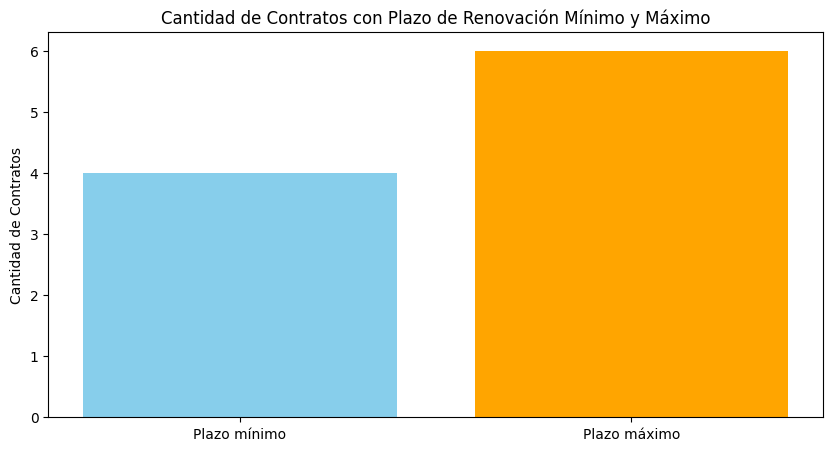

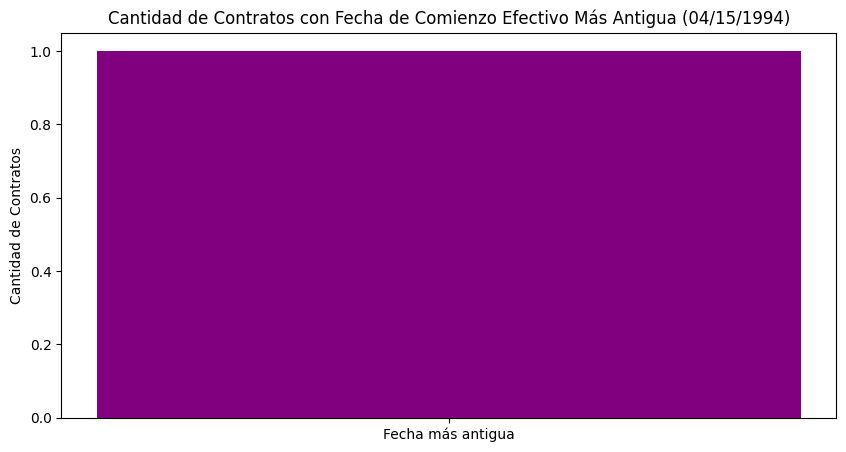

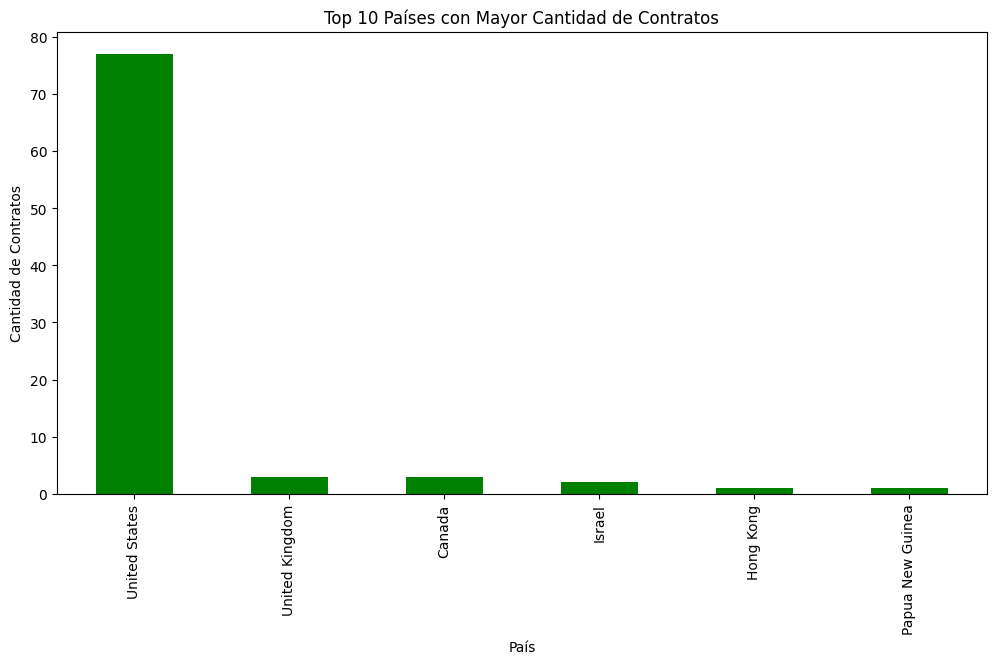

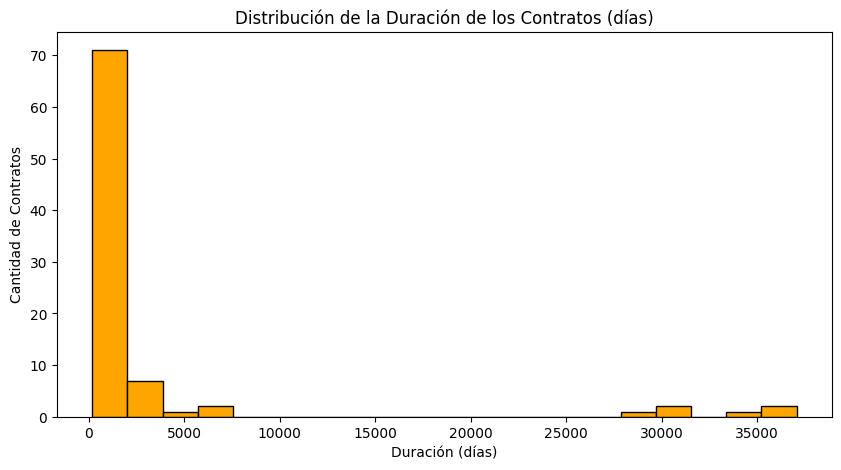

In [477]:
# Importar matplotlib para gráficos
import matplotlib.pyplot as plt
import pandas as pd

# Cargar el CSV generado como un nuevo DataFrame para el análisis
df_limpio = pd.read_csv("dataset_limpio.csv")

# Convertir columnas de fechas a formato datetime para cálculos y evitar errores
for col in ['Agreement Date-Answer', 'Effective Date-Answer', 'Expiration Date-Answer']:
    df_limpio[col] = pd.to_datetime(df_limpio[col], format='%m/%d/%Y', errors='coerce')

# Obtener el plazo de renovación más breve y más extenso
plazo_min = df_limpio['Renewal Term-Answer'].min()
plazo_max = df_limpio['Renewal Term-Answer'].max()

# Filtrar los contratos que cumplen con el plazo de renovación más breve y más extenso
contratos_plazo_min = df_limpio[df_limpio['Renewal Term-Answer'] == plazo_min]
contratos_plazo_max = df_limpio[df_limpio['Renewal Term-Answer'] == plazo_max]

# Graficar contratos con plazo de renovación mínimo y máximo
plt.figure(figsize=(10, 5))
plt.bar(['Plazo mínimo', 'Plazo máximo'], [len(contratos_plazo_min), len(contratos_plazo_max)], color=['skyblue', 'orange'])
plt.title('Cantidad de Contratos con Plazo de Renovación Mínimo y Máximo')
plt.ylabel('Cantidad de Contratos')
plt.show()

# Fecha más antigua en la columna 'Effective Date-Answer'
fecha_mas_antigua = df_limpio['Effective Date-Answer'].min()

# Verificar que 'fecha_mas_antigua' no sea NaT (valor nulo después de convertir a datetime)
if pd.notnull(fecha_mas_antigua):
    contratos_fecha_mas_antigua = df_limpio[df_limpio['Effective Date-Answer'] == fecha_mas_antigua]

    # Graficar la cantidad de contratos que inician en la fecha más antigua
    plt.figure(figsize=(10, 5))
    plt.bar(['Fecha más antigua'], [len(contratos_fecha_mas_antigua)], color='purple')
    plt.title(f'Cantidad de Contratos con Fecha de Comienzo Efectivo Más Antigua ({fecha_mas_antigua.strftime("%m/%d/%Y")})')
    plt.ylabel('Cantidad de Contratos')
    plt.show()
else:
    print("Error: No se encontró ninguna fecha válida en la columna 'Effective Date-Answer'.")

# Contar la frecuencia de cada país en la columna 'Country'
pais_frecuencia = df_limpio['Country'].value_counts().head(10)  # Tomar los 10 países más frecuentes

# Graficar la frecuencia de los países con más contratos
plt.figure(figsize=(12, 6))
pais_frecuencia.plot(kind='bar', color='green')
plt.title('Top 10 Países con Mayor Cantidad de Contratos')
plt.ylabel('Cantidad de Contratos')
plt.xlabel('País')
plt.show()

# Calcular la duración del contrato (en días)
df_limpio['Duración Contrato (días)'] = (df_limpio['Expiration Date-Answer'] - df_limpio['Effective Date-Answer']).dt.days

# Graficar la duración de los contratos
plt.figure(figsize=(10, 5))
plt.hist(df_limpio['Duración Contrato (días)'], bins=20, color='orange', edgecolor='black')
plt.title('Distribución de la Duración de los Contratos (días)')
plt.xlabel('Duración (días)')
plt.ylabel('Cantidad de Contratos')
plt.show()
